## Sentiment analysis - TFIDF feature weighting with RNN classification

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')https://colab.research.google.com/drive/1T5HSHMa4IJkFD2Sh5m_ZzrGORkG6VnTS#scrollTo=nl1d0wVyKDAf

`Term Weighting = TFIDF`

# Libraries


In [ ]:
#!pip install keras
#!pip install gdown

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold #Import KFold

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, SimpleRNN
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# !gdown --id DH8Ec6iVDMKZMmUjQe370bMMPWIK7Cj

In [ ]:
df_lazada = pd.read_csv('/content/drive/MyDrive/Dataset/dataset_next.csv')
df_lazada

,review,label,cleansing,case_folding,no_unwanted,tokenize,stemming,clean
0,Woi ngnt lu kalo iklan jangan maksa napa kontool,-1,Woi ngnt lu kalo iklan jangan maksa napa kontool,woi ngnt lu kalo iklan jangan maksa napa kontool,woi ngnt lu kalo iklan jangan maksa napa kontool,"['woi', 'ngnt', 'lu', 'kalo', 'iklan', 'jangan...","['woi', 'ngnt', 'lu', 'kalo', 'iklan', 'jangan...",woi ngnt lu kalo iklan jangan maksa napa kontool
1,"Ini aplikasi yang bagus, cuma karena sering ba...",-1,Ini aplikasi yang bagus cuma karena sering bat...,ini aplikasi yang bagus cuma karena sering bat...,ini aplikasi yang bagus cuma karena sering bat...,"['ini', 'aplikasi', 'yang', 'bagus', 'cuma', '...","['ini', 'aplikasi', 'yang', 'bagus', 'cuma', '...",ini aplikasi yang bagus cuma karena sering bat...
2,"Suka belanja di lazada,tapi akhir akhir ini, g...",-1,Suka belanja di lazada tapi akhir akhir ini gr...,suka belanja di lazada tapi akhir akhir ini gr...,suka belanja di lazada tapi akhir akhir ini gr...,"['suka', 'belanja', 'di', 'lazada', 'tapi', 'a...","['suka', 'belanja', 'di', 'lazada', 'tapi', 'a...",suka belanja di lazada tapi akhir akhir ini gr...
3,Banyak barang ga sesuai chuak.,-1,Banyak barang ga sesuai chuak,banyak barang ga sesuai chuak,banyak barang ga sesuai chuak,"['banyak', 'barang', 'ga', 'sesuai', 'chuak']","['banyak', 'barang', 'ga', 'sesuai', 'chuak']",banyak barang ga sesuai chuak
4,"Aplikasi ga jelas, dikasi limit 200rbu tapi ga...",-1,Aplikasi ga jelas dikasi limit rbu tapi ga bis...,aplikasi ga jelas dikasi limit rbu tapi ga bis...,aplikasi ga jelas dikasi limit rbu tapi ga bis...,"['aplikasi', 'ga', 'jelas', 'dikasi', 'limit',...","['aplikasi', 'ga', 'jelas', 'kasi', 'limit', '...",aplikasi ga jelas kasi limit rbu tapi ga bisa ...
...,...,...,...,...,...,...,...,...
5953,banyak diskon.respon cepat,1,banyak diskon respon cepat,banyak diskon respon cepat,banyak diskon respon cepat,"['banyak', 'diskon', 'respon', 'cepat']","['banyak', 'diskon', 'respon', 'cepat']",banyak diskon respon cepat
5954,Ga dapet fitur lazada paylater,-1,Ga dapet fitur lazada paylater,ga dapet fitur lazada paylater,ga dapet fitur lazada paylater,"['ga', 'dapet', 'fitur', 'lazada', 'paylater']","['ga', 'dapet', 'fitur', 'lazada', 'paylater']",ga dapet fitur lazada paylater
5955,Pembelian yang jujur dan amanah,1,Pembelian yang jujur dan amanah,pembelian yang jujur dan amanah,pembelian yang jujur dan amanah,"['pembelian', 'yang', 'jujur', 'dan', 'amanah']","['beli', 'yang', 'jujur', 'dan', 'amanah']",beli yang jujur dan amanah
5956,SELALU BERIKAN YANG TERBAIK DALAM MELAYANI KEB...,1,SELALU BERIKAN YANG TERBAIK DALAM MELAYANI KEB...,selalu berikan yang terbaik dalam melayani keb...,selalu berikan yang terbaik dalam melayani keb...,"['selalu', 'berikan', 'yang', 'terbaik', 'dala...","['selalu', 'ikan', 'yang', 'baik', 'dalam', 'l...",selalu ikan yang baik dalam layan butuh langga...


In [ ]:
# constants
TFIDF_MAX_FEATURES = 1000
EPOCH_VAL = 5
NUM_CLASSES = 3
BATCH_SIZE = 32

In [ ]:
# df = df_lazada.dropna()
# df = df_lazada.reset_index(drop=True)

In [ ]:
df_lazada['label'].value_counts()

 1    3349
-1    2609
Name: label, dtype: int64

In [ ]:
# Split the data into features and labels
reviews = df_lazada['clean'].astype(str).values

raw_label = df_lazada['label']
# labels = pd.get_dummies(raw_label).astype(int).values
labels = to_categorical(raw_label, num_classes=NUM_CLASSES)

In [ ]:
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
review_train, review_test, label_train, label_test = train_test_split(reviews, labels, test_size=0.3, random_state=42)

In [ ]:
# Tokenize and vectorize the tweets using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES)
tfidf_review_train = tfidf_vectorizer.fit_transform(review_train).toarray()
tfidf_review_test = tfidf_vec  torizer.transform(review_test).toarray()

max_length = tfidf_review_train.shape[1]

# add an additional dimension for the max_length dimension
tfidf_review_train = tfidf_review_train.reshape(tfidf_review_train.shape[0], 1, tfidf_review_train.shape[1])
tfidf_review_test = tfidf_review_test.reshape(tfidf_review_test.shape[0], 1, tfidf_review_test.shape[1])



In [ ]:
print("x_train: ", tfidf_review_train.shape)
print("x_test: ", tfidf_review_test.shape)
print("y_train: ", label_train.shape)
print("y_test: ", label_test.shape)
print("max_length: ", max_length)

x_train:  (4170, 1, 1000)
x_test:  (1788, 1, 1000)
y_train:  (4170, 3)
y_test:  (1788, 3)
max_length:  1000


In [ ]:
def rnn_model():
    model = Sequential()
    # # add bidirectional LSTM layer
    # model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(max_length,)))
    model.add(SimpleRNN(units=64, input_shape=(1, max_length)))
    # add dropout layer to reduce overfitting
    model.add(Dropout(0.8))
    # add dense layer with softmax activation for multi-class classification
    model.add(Dense(units=3, activation='softmax'))
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = rnn_model()
model_fit_result = model.fit(tfidf_review_train, label_train, batch_size=BATCH_SIZE, epochs=EPOCH_VAL, validation_data=(tfidf_review_test, label_test))


Epoch 1/5
131/131 [==============================] - 7s 28ms/step - loss: 0.8152 - accuracy: 0.6597 - val_loss: 0.6014 - val_accuracy: 0.8132
Epoch 2/5
131/131 [==============================] - 2s 18ms/step - loss: 0.5406 - accuracy: 0.7916 - val_loss: 0.4421 - val_accuracy: 0.8523
Epoch 3/5
131/131 [==============================] - 2s 12ms/step - loss: 0.4315 - accuracy: 0.8412 - val_loss: 0.3853 - val_accuracy: 0.8529
Epoch 4/5
131/131 [==============================] - 1s 11ms/step - loss: 0.3915 - accuracy: 0.8501 - val_loss: 0.3695 - val_accuracy: 0.8574
Epoch 5/5
131/131 [==============================] - 1s 11ms/step - loss: 0.3603 - accuracy: 0.8585 - val_loss: 0.3583 - val_accuracy: 0.8607


In [ ]:
# Predict the labels for the testing data
label_pred_prob = model.predict(tfidf_review_test)
label_pred = label_pred_prob.argmax(axis=1)-1
label_test_one_dim = np.argmax(label_test, axis=1)-1

56/56 [==============================] - 0s 2ms/step


In [ ]:
print("RNN-TFIDF \n")

# print(accuracy_score(label_test_one_dim, label_pred))
print(confusion_matrix(label_test_one_dim, label_pred))
print(classification_report(label_test_one_dim, label_pred))
print("Accuracy: ",accuracy_score(label_test_one_dim, label_pred))
print("Precision: ",precision_score(label_test_one_dim, label_pred, average="macro"))
print("Recall: ",recall_score(label_test_one_dim, label_pred, average="macro"))
print("F1: ",f1_score(label_test_one_dim, label_pred,  average="macro"))

RNN-TFIDF 

[[852 129]
 [120 687]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       981
           1       0.84      0.85      0.85       807

    accuracy                           0.86      1788
   macro avg       0.86      0.86      0.86      1788
weighted avg       0.86      0.86      0.86      1788

Accuracy:  0.860738255033557
Precision:  0.8592274872912128
Recall:  0.8599013221468117
F1:  0.8595421234500598


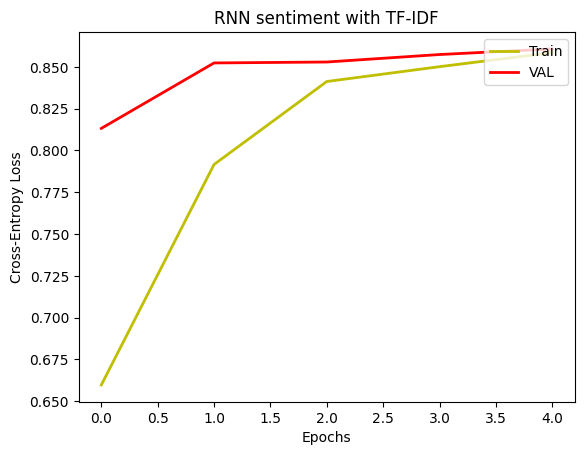

In [ ]:
plt.figure()
plt.plot(model_fit_result.history['accuracy'], lw=2.0, color='y', label='Train')
plt.plot(model_fit_result.history['val_accuracy'], lw=2.0, color='r', label='VAL')
plt.title('RNN sentiment with TF-IDF')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc ='upper right')
plt.show()

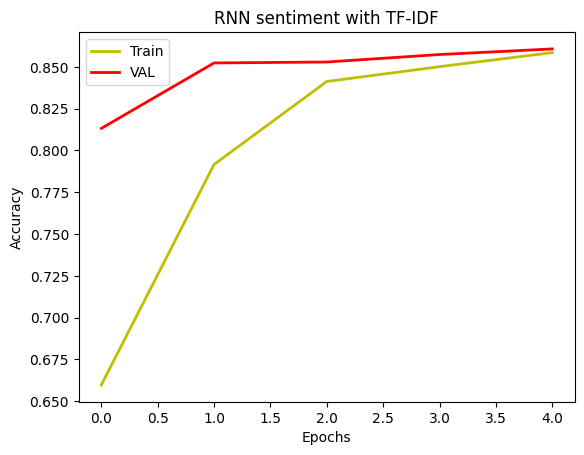

In [ ]:
plt.figure()
plt.plot(model_fit_result.history['accuracy'], lw=2.0, color='y', label='Train')
plt.plot(model_fit_result.history['val_accuracy'], lw=2.0, color='r', label='VAL')
plt.title('RNN sentiment with TF-IDF')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                68160     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 68355 (267.01 KB)
Trainable params: 68355 (267.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Implement with k-fold cross validation

In [ ]:
# define the range of K values to test
k_values = range(2, 11)

# create an array to store the maximum accuracy achieved for each K value
max_acc = np.zeros(len(k_values))

# loop over the K values
for i, k in enumerate(k_values):
    # create the KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # perform cross-validation
    acc_list = []
    for train_idx, test_idx in kf.split(tfidf_review_train, label_train):
        X_train, X_test = tfidf_review_train[train_idx], tfidf_review_train[test_idx]
        y_train, y_test = label_train[train_idx], label_train[test_idx]

        # define and fit the model
        model = rnn_model()
        model_fit_kfold = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_VAL, validation_data=(X_test, y_test))

        # evaluate the model on the test set and store the accuracy
        acc = model.evaluate(X_test, y_test)[1]
        acc_list.append(acc)

    # calculate the maximum accuracy achieved for this K value
    max_acc[i] = np.max(acc_list)

# find the K value with the highest maximum accuracy
best_k = k_values[np.argmax(max_acc)]

print(f"Best K value: {best_k}")

Epoch 1/5
66/66 [==============================] - 2s 12ms/step - loss: 0.9158 - accuracy: 0.5971 - val_loss: 0.7499 - val_accuracy: 0.7616
Epoch 2/5
66/66 [==============================] - 0s 6ms/step - loss: 0.6779 - accuracy: 0.7295 - val_loss: 0.5923 - val_accuracy: 0.8293
Epoch 3/5
66/66 [==============================] - 0s 7ms/step - loss: 0.5525 - accuracy: 0.8106 - val_loss: 0.5010 - val_accuracy: 0.8273
Epoch 4/5
66/66 [==============================] - 0s 7ms/step - loss: 0.4761 - accuracy: 0.8230 - val_loss: 0.4435 - val_accuracy: 0.8456
Epoch 5/5
66/66 [==============================] - 0s 2ms/step - loss: 0.4112 - accuracy: 0.8499
Epoch 1/5
66/66 [==============================] - 2s 11ms/step - loss: 0.9233 - accuracy: 0.5871 - val_loss: 0.7570 - val_accuracy: 0.7914
Epoch 2/5
66/66 [==============================] - 0s 7ms/step - loss: 0.6901 - accuracy: 0.7357 - val_loss: 0.5977 - val_accuracy: 0.8106
Epoch 3/5
66/66 [==============================] - 0s 7ms/step - lo

In [ ]:
print("Max accuration Word2Vec-TFIDF in 10 times k-fold cross validation: \n")

for i, val in enumerate(acc_list, start=2):
    print("Fold {}: {}".format(i, val))

print('\n')
print("max accuracy: ", np.max(acc_list)*100)
print("avg accuracy: ", np.mean(acc_list)*100)

best_k = k_values[np.argmax(max_acc)]
print(f"Best K value: {best_k}")

Max accuration Word2Vec-TFIDF in 10 times k-fold cross validation: 

Fold 2: 0.8417266011238098
Fold 3: 0.8609112501144409
Fold 4: 0.8705036044120789
Fold 5: 0.88968825340271
Fold 6: 0.8321343064308167
Fold 7: 0.8441246747970581
Fold 8: 0.8465228080749512
Fold 9: 0.8177458047866821
Fold 10: 0.8561151027679443
Fold 11: 0.8585131764411926


max accuracy:  88.968825340271
avg accuracy:  85.17985582351685
Best K value: 10


_`K-fold cross validation with choosen K value (best accuracy)`_

In [ ]:
# split data into K folds

Best_K_value = 9

actual_classes = np.empty([0], dtype=int)
predicted_classes = np.empty([0], dtype=int)

kf = KFold(n_splits=Best_K_value, random_state=0, shuffle = True)
for fold, (train_idx, val_idx) in enumerate(kf.split(tfidf_review_train, label_train)):

    # Split train data into train and validation sets
    x_train_fold = tfidf_review_train[train_idx]
    y_train_fold = label_train[train_idx]
    x_val_fold = tfidf_review_train[val_idx]
    y_val_fold = label_train[val_idx]

    # build and compile the model
    model = rnn_model()

    # train the model
    result_fit_kfold = model.fit(tfidf_review_train, label_train, batch_size=BATCH_SIZE, epochs=EPOCH_VAL, validation_data=(tfidf_review_test, label_test))

    # evaluate the model on test set
    score = model.evaluate(tfidf_review_test, label_test, batch_size=BATCH_SIZE, verbose=1)
    print("Fold %d: %s: %.2f%%" % (fold+1, model.metrics_names[1], score[1]*100))

    # Predict the labels for the testing data
    label_pred_prob = model.predict(tfidf_review_test)
    label_pred = label_pred_prob.argmax(axis=1)-1
    label_test_one_dim = np.argmax(label_test, axis=1)-1

    actual_classes = np.append(actual_classes, label_test_one_dim)
    predicted_classes = np.append(predicted_classes, label_pred)

Epoch 1/5
131/131 [==============================] - 2s 8ms/step - loss: 0.8233 - accuracy: 0.6655 - val_loss: 0.6093 - val_accuracy: 0.7931
Epoch 2/5
131/131 [==============================] - 1s 8ms/step - loss: 0.5432 - accuracy: 0.7933 - val_loss: 0.4453 - val_accuracy: 0.8507
Epoch 3/5
131/131 [==============================] - 1s 7ms/step - loss: 0.4353 - accuracy: 0.8365 - val_loss: 0.3876 - val_accuracy: 0.8579
Epoch 4/5
131/131 [==============================] - 1s 9ms/step - loss: 0.3868 - accuracy: 0.8554 - val_loss: 0.3641 - val_accuracy: 0.8596
Epoch 5/5
56/56 [==============================] - 0s 3ms/step - loss: 0.3568 - accuracy: 0.8585
Fold 1: accuracy: 85.85%
56/56 [==============================] - 0s 3ms/step
Epoch 1/5
131/131 [==============================] - 3s 8ms/step - loss: 0.8139 - accuracy: 0.6719 - val_loss: 0.5884 - val_accuracy: 0.8238
Epoch 2/5
131/131 [==============================] - 1s 5ms/step - loss: 0.5346 - accuracy: 0.7885 - val_loss: 0.4357 - 

In [ ]:
print("RNN-TFIDF W/ kfold (Best_K_value = %2d): \n" %(Best_K_value))
print(confusion_matrix(label_test_one_dim, label_pred))
print(classification_report(label_test_one_dim, label_pred))
print("Accuracy: ",accuracy_score(label_test_one_dim, label_pred))
print("Precision: ",precision_score(label_test_one_dim, label_pred, average="macro"))
print("Recall: ",recall_score(label_test_one_dim, label_pred, average="macro"))
print("F1: ",f1_score(label_test_one_dim, label_pred,  average="macro"))

RNN-TFIDF W/ kfold (Best_K_value =  9): 

[[866 115]
 [133 674]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       981
           1       0.85      0.84      0.84       807

    accuracy                           0.86      1788
   macro avg       0.86      0.86      0.86      1788
weighted avg       0.86      0.86      0.86      1788

Accuracy:  0.8612975391498882
Precision:  0.8605563738643587
Recall:  0.8589823751653157
F1:  0.859679501784765


In [ ]:
model.metrics_names

['loss', 'accuracy']

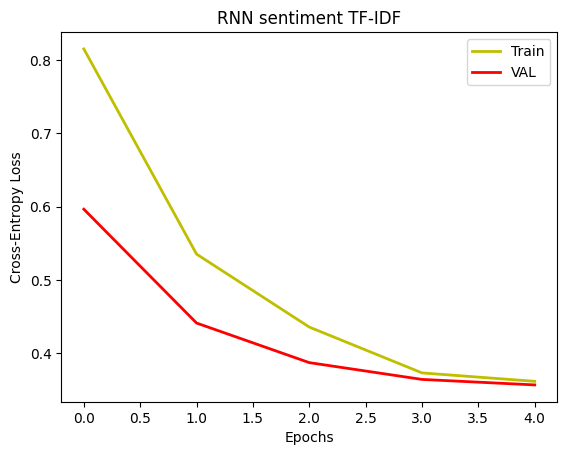

In [ ]:
plt.figure()
plt.plot(result_fit_kfold.history['loss'], lw=2.0, color='y', label='Train')
plt.plot(result_fit_kfold.history['val_loss'], lw=2.0, color='r', label='VAL')
plt.title('RNN sentiment TF-IDF')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc ='upper right')
plt.show()

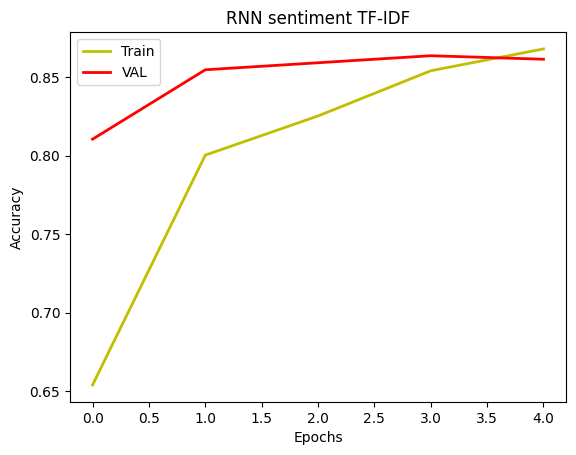

In [ ]:
plt.figure()
plt.plot(result_fit_kfold.history['accuracy'], lw=2.0, color='y', label='Train')
plt.plot(result_fit_kfold.history['val_accuracy'], lw=2.0, color='r', label='VAL')
plt.title('RNN sentiment TF-IDF')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_63 (SimpleRNN)   (None, 64)                68160     
                                                                 
 dropout_63 (Dropout)        (None, 64)                0         
                                                                 
 dense_63 (Dense)            (None, 3)                 195       
                                                                 
Total params: 68355 (267.01 KB)
Trainable params: 68355 (267.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
arr_conf_matrix = confusion_matrix(label_test_one_dim, label_pred)
arr_conf_matrix

array([[866, 115],
       [133, 674]])

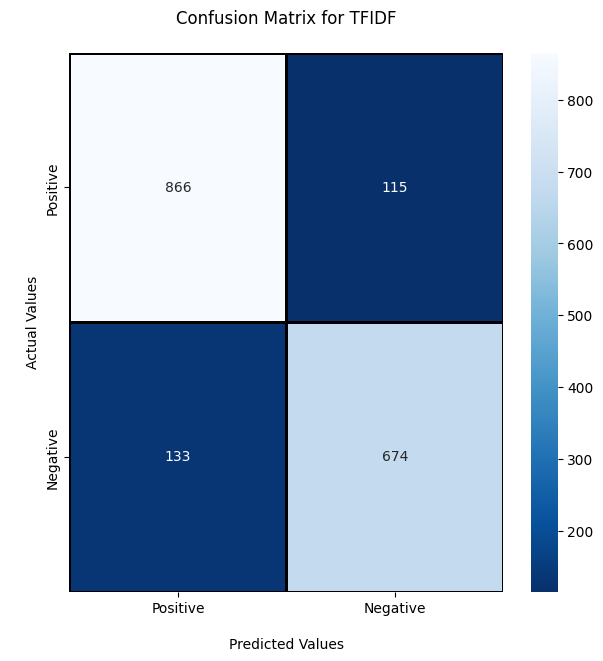

In [ ]:
plt.figure(figsize = (7, 7))

# Membuat heatmap menggunakan Seaborn
ax = sns.heatmap(arr_conf_matrix, linecolor = 'black',
                    linewidth = 1,
                    annot = True,
                    fmt = '', cmap='Blues_r', xticklabels = ['Positive', 'Negative'],
                    yticklabels = ['Positive', 'Negative'] )
ax.set_title("Confusion Matrix for TFIDF\n")
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("\nActual Values")


# Menampilkan plot
plt.show()